# EXPLORATION_04 작사가 인공지능 만들기

## 1. 데이터 읽어오기

### 사용할 라이브러리 부르기 & 파일 내용 확인

In [187]:
import glob
import os
import re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[60000])



"""
# '('를 포함한 문자 확인하는 코드
sum=0
a=[]
for i in range(len(raw_corpus)):
    if "(" in raw_corpus[i]:
        a.append(raw_corpus[i])
print(a)
"""
"""
# 길이가 0인 문장 개수 확인하는 코드
sum=0
a=[]
for sentence in raw_corpus:
    if len(sentence) == 0: 
        sum+=1
print(sum)  # 11102개
"""

데이터 크기: 187088
Examples:
 I am the king and will not be headed
[]


## 2. 데이터 정제하기

### 원치 않는 문자 제외하기 ( 길이가 0 이거나 :로 끝나는 문장)

In [188]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

I hear you callin', "Here I come baby"
To save you, oh oh
Baby no more stallin'
These hands have been longing to touch you baby
And now that you've come around, to seein' it my way
You won't regret it baby, and you surely won't forget it baby
It's unbelieveable how your body's calling for me
I can just hear it callin' callin' for me My body's callin' for you
My body's callin' for you
My body's callin' for you


### 지저분한 문장을 넣어도 예쁘게 변환해 주는 정제 함수 만들기

In [189]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'\[[^)]*\]','',sentence) # []안의 내용 포함 []제거
    sentence = sentence.lower().strip() # 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) #특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?!¿,.']+", " ", sentence) # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence= re.sub(r'\s\'', " ", sentence) # 어퍼스트로피 제외한 '' 지우기
    sentence= re.sub(r'\'\s', " ", sentence)# 어퍼스트로피 제외한 '' 지우기
    sentence = sentence.strip() # 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
   
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This, @_'is' ;;;(sample)  he's  [sten'']    sentence. sis' ah oh "))


<start> this , is sample he's sentence . sis ah oh <end>


### 정제 데이터 구축하기

In [190]:
corpus = []
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0 : continue # 길이가 0인 문장
    if sentence[-1] == ":": continue # : 으로 끝나는 문장
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15 : continue # 길이가 15를 넘는 문장
    if len(preprocessed_sentence.split())==2: continue # '<start> <end>' 인 문장
    if len(preprocessed_sentence.split())==3: continue # '<start> oh <end>' 와 같은 문장  
           
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> i hear you callin , here i come baby <end>',
 '<start> to save you , oh oh <end>',
 "<start> baby no more stallin' <end>",
 '<start> these hands have been longing to touch you baby <end>',
 "<start> and now that you've come around , to seein it my way <end>",
 "<start> you won't regret it baby , and you surely won't forget it baby <end>",
 "<start> it's unbelieveable how your body's calling for me <end>",
 "<start> my body's callin for you <end>",
 "<start> my body's callin for you <end>",
 "<start> my body's callin for you tell me , what's your desire <end>"]

## 3. 평가 데이터셋 분리

### tf.keras.preprocessing.text.Tokenizer 패키지 사용하기

In [191]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12000개 이상의 단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

In [192]:
# 생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력
print(tensor[:3, :10])

[[  2   6 189   7 925   4  93   6  66  49]
 [  2  10 586   7   4  43  43   3   0   0]
 [  2  49  36  95   1   3   0   0   0   0]]


In [193]:
# 단어사전이 어떻게 구축되었는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


In [194]:
# 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 함
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2   6 189   7 925   4  93   6  66  49   3   0   0   0]
[  6 189   7 925   4  93   6  66  49   3   0   0   0   0]


In [195]:
print(src_input.shape)
print(tgt_input.shape)

(156135, 14)
(156135, 14)


In [196]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,test_size=0.2,shuffle=True,random_state=111)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape) 
# 학습 데이터 개수가 124960보다 크다면 위 Step 3.의 데이터 정제 과정을 다시 한번 검토해 보시기를 권합니다.

Source Train: (124908, 14)
Target Train: (124908, 14)


### tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성

In [198]:
# 데이터셋 객체를 생성
BUFFER_SIZE1 = len(enc_train)
BUFFER_SIZE2 = len(enc_val)
BATCH_SIZE = 256
steps_per_epoch1 = len(enc_train) // BATCH_SIZE
steps_per_epoch2 = len(enc_val) // BATCH_SIZE
 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# train dataset 만들기
dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE1)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
print(dataset_train)
# validation dataset 만들기
dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE2)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)
dataset_val

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 4. 인공지능 만들기

### 모델 만들기

In [199]:
from keras.layers import Bidirectional,LSTM
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size,mask_zero=True)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size,activation='softmax')
        
    def call(self, x):
        out = self.embedding(x)                                           
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 150
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [201]:
model.summary()

Model: "text_generator_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      multiple                  1050150   
_________________________________________________________________
lstm_16 (LSTM)               multiple                  18014208  
_________________________________________________________________
lstm_17 (LSTM)               multiple                  33562624  
_________________________________________________________________
dense_8 (Dense)              multiple                  14345049  
Total params: 66,972,031
Trainable params: 66,972,031
Non-trainable params: 0
_________________________________________________________________


### 모델 학습시키기

In [202]:
optimizer = tf.keras.optimizers.Adam() # default learning_rate=0.001
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_train, epochs=10,validation_data=dataset_val) 

Epoch 1/10
487/487 [==============================] - 333s 672ms/step - loss: 3.5434 - val_loss: 2.9593
Epoch 2/10
487/487 [==============================] - 324s 666ms/step - loss: 2.8728 - val_loss: 2.7497
Epoch 3/10
487/487 [==============================] - 325s 668ms/step - loss: 2.6292 - val_loss: 2.6124
Epoch 4/10
487/487 [==============================] - 326s 669ms/step - loss: 2.4078 - val_loss: 2.4954
Epoch 5/10
487/487 [==============================] - 325s 666ms/step - loss: 2.1908 - val_loss: 2.4021
Epoch 6/10
487/487 [==============================] - 324s 664ms/step - loss: 1.9754 - val_loss: 2.3230
Epoch 7/10
487/487 [==============================] - 325s 667ms/step - loss: 1.7711 - val_loss: 2.2664
Epoch 8/10
487/487 [==============================] - 325s 668ms/step - loss: 1.5833 - val_loss: 2.2268
Epoch 9/10
487/487 [==============================] - 324s 664ms/step - loss: 1.4202 - val_loss: 2.1998
Epoch 10/10
487/487 [==============================] - 324s 665m

## 5. 잘 만들어졌는지 평가하기

### 작문을 시켜보고 직접 평가하기

In [203]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### 문장 생성 함수 실행하기

In [205]:
generate_text(model, tokenizer, init_sentence="<start> I met")

'<start> i met you so much <end> '

In [206]:
generate_text(model, tokenizer, init_sentence="<start> We")

'<start> we can risk it all we can risk it all <end> '

In [207]:
generate_text(model, tokenizer, init_sentence="<start> baby")

'<start> baby , baby , baby oh <end> '

In [208]:
generate_text(model, tokenizer, init_sentence="<start> Cheer")

'<start> cheer in hand <end> '

In [209]:
generate_text(model, tokenizer, init_sentence="<start> kiss  ")

'<start> kiss my body its a frank white thing <end> '

In [210]:
generate_text(model, tokenizer, init_sentence="<start> she ")

'<start> she said she can take this d she said she can take it <end> '

In [211]:
generate_text(model, tokenizer, init_sentence="<start> i ")

"<start> i don't wanna be alone forever <end> "

In [212]:
generate_text(model, tokenizer, init_sentence="<start> love ")

'<start> love is a beautiful thing <end> '

In [215]:
generate_text(model, tokenizer, init_sentence="<start> beautiful")

'<start> beautiful people say yes <end> '

In [216]:
generate_text(model, tokenizer, init_sentence="<start> man")

'<start> man i swear to god i aint nervous <end> '

In [217]:
generate_text(model, tokenizer, init_sentence="<start> they")

"<start> they say that u ain't u know what <end> "

In [218]:
generate_text(model, tokenizer, init_sentence="<start> I like")

"<start> i like the way how you're lovin me <end> "

In [219]:
generate_text(model, tokenizer, init_sentence="<start> What")

'<start> what you want nixga what you what you want nixga <end> '

In [220]:
generate_text(model, tokenizer, init_sentence="<start> What should")

'<start> what should we do for bread and cheese ? <end> '

In [221]:
generate_text(model, tokenizer, init_sentence="<start> Why")

'<start> why you wanna get with me <end> '

In [222]:
generate_text(model, tokenizer, init_sentence="<start> how")

"<start> how many times you don't want me to leave ? <end> "

***

# 회고

### 전처리 과정
기존 노드의 전처리과정 + `추가`
1. 데이터를 확인해보면 문장에 [Chorus] 와 같은 단어들이 있어서 [] 대괄호와 대괄호 안에 있는 단어들은 필요없다고 판단하여 없애주었다.
2. I'm 과 같이 어퍼스트로피를 살리고 싶었다. 다만, '' (작은 따옴표 두개) 와 구분을 해야돼서 보통 어퍼스트로피는 알파벳 사이에 존재하므로 (아닌 경우도 있지만..) (공백)' 이나 '(공백)을 없애주었다. 작은 따옴표는 보통  (공백)'문장'(공백)의 형태로 존재한다고 생각했기 때문..
3. if len(preprocessed_sentence.split())==2: continue => 전처리한 문장 중 길이가 2인 문장들을 살펴보니 `<start> <end>` 이 형태여서 제외
4. if len(preprocessed_sentence.split())==3: continue =>  `<start> oh <end>` 이렇게 start와 end를 제외하고 단어가 1개만 존재하는 문장도 중요도가 낮다고 생각하여 제외시켰다.

### 새롭게 알게 되거나 힘들었던 점, 시도해본 것

✔ 학습 데이터 개수가 124960보다 크다면 정제부분을 다시 해보라는 문구가 있었다. 처음에 124960보다 큰 값이 나와서 preprocess_sentence(sentence) 이 함수에서 정규식부분을 건들면 된다고 생각하였다. 하지만 변경하여도 학습 데이터 개수의 변화가 없었다. 

~~~
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0 : continue # 길이가 0인 문장
    if sentence[-1] == ":": continue # : 으로 끝나는 문장
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15 : continue # 길이가 15를 넘는 문장
    if len(preprocessed_sentence.split())==2: continue # '<start> <end>' 인 문장
    if len(preprocessed_sentence.split())==3: continue # '<start> oh <end>' 와 같은 문장  
           
    corpus.append(preprocessed_sentence)
~~~
오히려 위의 코드를 추가하니 학습 데이터 개수가 줄어드는 것을 확인하였다. 따라서 정규식으로 하는 전처리 부분은 보통 한 문장을 좀 더 깔끔하게 우리가 원하는 대로 만드는 거여서 전체 문장의 수가 줄어들기 보다는 한 문장 자체를 변경시키는 단계이고, 위에 있는 코드는 어떤 조건을 만족하는 문장들은 제외시키기때문에 전체 문장 수가 줄어드는 데 영향을 미치는 것 같았다.

✔ 모델 변경시, 심층 RNN 모델(Deep RNN) 즉, 여러 개의 LSTM 셀로 이루어진 layer를 여러 층 쌓아 심층 RNN 모델을 구현해 보기위해 rnn3 레이어 추가하였지만 오히려 val_loss가 높아졌다. 검색해보니 LSTM 자체는 많이 쌓아도 성능이 그렇게 올라가지 않아서 2~3층 정도만 쌓는 것이 보통이라고 한다.



✔ Dropout 레이어를 추가했는데 오히려 val loss가 높아졌다. 왜 그럴까..?
[블로그 참고](https://wjddyd66.github.io/keras/Keras(4-2))
<br> LSTM Model에 Dropout Layer를 추가할 때 Sequencial()에 Layer를 쌓는것이 아닌, Keras가 구현해둔 LSTM Layer안에서의 Dropout option을 추가하여서 구현해야된다는 블로그 글이다. RNN Network에 기존의 Dropout을 적용하게 되면 Memory에 영향을 미치게 되고, 과거의 중요한 정보를 잃어버리게 되어 Model의 성능이 나빠진다고 설명하고 있다. 그래서 드롭아웃 레이어 적용시 안 좋은 결과가 나온건가..? 궁금하다...

#### + 파라미터를 크게 하고 드롭아웃을 적용하니 시간이 엄청 오래 걸렸다..


✔ 단어장 개수를 12000개에서 20000개로 늘려봤을 때, val_loss는 안 좋아졌지만 문장 완성도는 좋아졌다. `<unk>`로 나오던 문장들이 다 잘 채워져서 생성되었다. 확실히 기억하는 단어가 많아져서 그런가보다..

✔ Deep Bidirectional RNN (양방향 RNN) 
 * 기존의 RNN은 한 방향(앞 -> 뒤)으로의 순서만 고려하였다고 볼 수도 있다. 반면, 양방향 RNN은 역방향으로의 순서도 고려하는 모델이다.
 * 실제로는 두 개의 RNN 모델(순방향, 역방향)을 만들어 학습 결과를 합치는 인공신경망 모델에 가깝다.
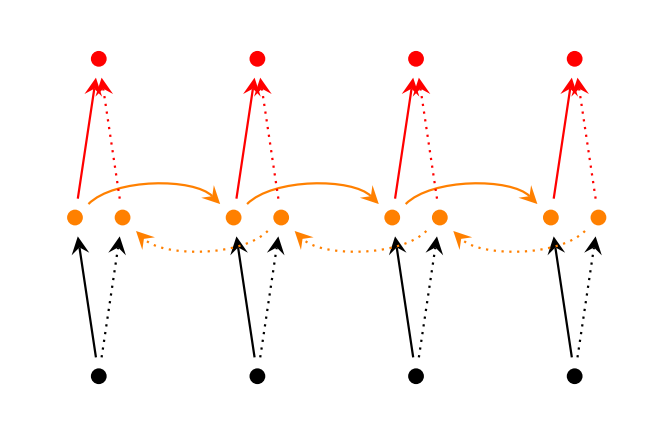

*  적용해보니 epoch 1 만에 val loss는 거의 0이 나와서 성능이 좋을 줄 알았지만 제대로 된 문장생성을 못한다
    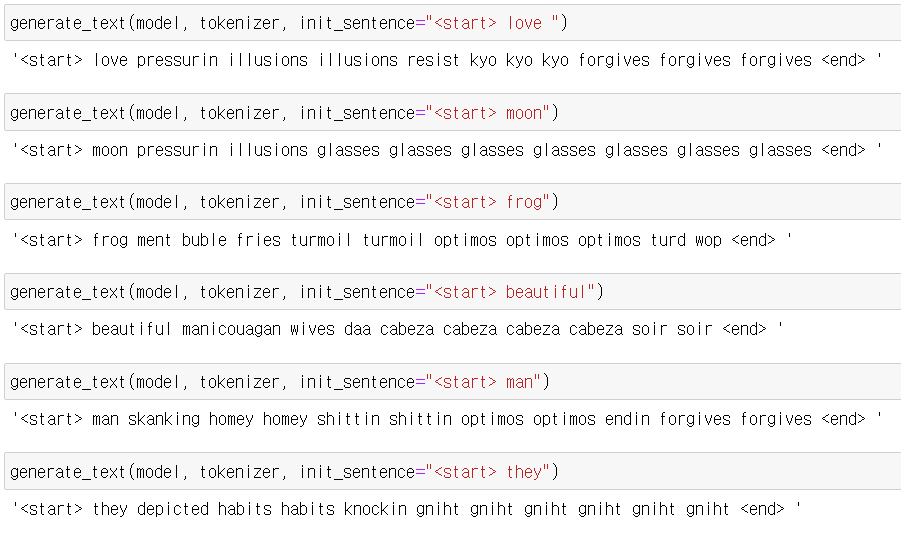

✔ tf.keras.layers.Dense의 default가 activation=None으로 되어있어서 softmax로 바꿔주었다. 

<br> `activation = 활성화 함수`
- linear : 디폴트 값으로 별도 활성화 함수 없이 입력 뉴런과 가중치의 계산 결과 그대로 출력. Ex) 선형 회귀
- sigmoid : 시그모이드 함수. 이진 분류 문제에서 출력층에 주로 사용되는 활성화 함수.
- softmax : 소프트맥스 함수. 셋 이상을 분류하는 다중 클래스 분류 문제에서 출력층에 주로 사용되는 활성화 함수.
- relu : 렐루 함수. 은닉층에 주로 사용되는 활성화 함수.

✔ 임배딩 레이어에 mask_zero=True 추가
<br> mask_zero=True를 해주면 0으로 패딩된 값이 학습에 영향을 미치지 않도록 해준다고 한다.
 * 패딩과 마스킹의 관계? 
<br>    : 입력층 데이터를 통일하기 위하여 패딩을 하고 패딩된 데이터에서 의미있는 데이터인지 아닌지를 구분하기 위하여 마스킹을 사용한다고 함. 
<br>    (예) 패딩으로 ['나는', '밥을', '먹는다', '0', '0', '0'] 이라는 자연어 데이터가 들어왔다고 할때, 의미가 존재하는 것은 앞의 3 단어고, 뒤의 0들은 의미가 없는 것! 이 뒷부분의 0들이 의미가 없다는 것을 알려주기 위한 정보가 필요한데 그것이 마스크 !

### 느낀점


* val_loss 2.2 이하를 맞추기가 너무 어렵다.. 계속 2.3, 2.3에서 내려가지않아서 눈물을 좀 흘렸다. 😂
* nlp 쉽지 않다..파라미터조정, 전처리과정 어디를 바꿔야될지 모르겠다.
* 어떻게 해야 성능을 올릴 수 있을까..?
* 아직 노드를 몇개 안 해봤지만 제일 어렵고 이해가 안 갔던 노드... 그래도 문장 생성하는 건 신기했다. 가사에 보통 사랑얘기가 많아서 그런지 생성되는 가사도 사랑관련 가사가 많았다.
